In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import ttest_ind
from scipy.stats import ks_2samp

CREATING THE DATAFRAME OF PAIRS OF DIRECTORS AND ACTORS

In [2]:
movie_industry = pd.read_csv("../data/movie_industry.csv", encoding = "ISO-8859-1" )
movie_industry.loc[movie_industry.rating == "Not specified", "rating"] = "NOT RATED"
movie_industry.loc[movie_industry.rating == "UNRATED", "rating"] = "NOT RATED"
movie_industry.head()

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,8000000.0,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,52287414.0,Stand by Me,R,1986-08-22,89,8.1,Wil Wheaton,299174,Stephen King,1986
1,6000000.0,Paramount Pictures,USA,John Hughes,Comedy,70136369.0,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.8,Matthew Broderick,264740,John Hughes,1986
2,15000000.0,Paramount Pictures,USA,Tony Scott,Action,179800601.0,Top Gun,PG,1986-05-16,110,6.9,Tom Cruise,236909,Jim Cash,1986
3,18500000.0,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,85160248.0,Aliens,R,1986-07-18,137,8.4,Sigourney Weaver,540152,James Cameron,1986
4,9000000.0,Walt Disney Pictures,USA,Randal Kleiser,Adventure,18564613.0,Flight of the Navigator,PG,1986-08-01,90,6.9,Joey Cramer,36636,Mark H. Baker,1986


In [3]:
val_genre=movie_industry['genre'].value_counts()
val_genre


Comedy       2080
Drama        1444
Action       1331
Crime         522
Adventure     392
Biography     359
Animation     277
Horror        277
Mystery        38
Fantasy        32
Thriller       18
Romance        15
Family         14
Sci-Fi         13
Musical         4
Western         2
War             2
Name: genre, dtype: int64

In [4]:
picked_genre = val_genre[:8].index
picked_genre


Index(['Comedy', 'Drama', 'Action', 'Crime', 'Adventure', 'Biography',
       'Animation', 'Horror'],
      dtype='object')

In [5]:
movie_industry['genre'][~ movie_industry['genre'].isin(picked_genre)] = 'Other_genre'
movie_industry['genre'].value_counts()

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Comedy         2080
Drama          1444
Action         1331
Crime           522
Adventure       392
Biography       359
Horror          277
Animation       277
Other_genre     138
Name: genre, dtype: int64

In [6]:
val_rating=movie_industry['rating'].value_counts()
val_rating

R            3392
PG-13        1995
PG            951
NOT RATED     308
G             147
NC-17          22
TV-MA           1
TV-PG           1
B               1
TV-14           1
B15             1
Name: rating, dtype: int64

In [7]:
picked_rating = val_rating[:5].index
picked_rating


Index(['R', 'PG-13', 'PG', 'NOT RATED', 'G'], dtype='object')

In [8]:
movie_industry['rating'][~ movie_industry['rating'].isin(picked_rating)] = 'Other_rating'
movie_industry['rating'].value_counts()

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


R               3392
PG-13           1995
PG               951
NOT RATED        308
G                147
Other_rating      27
Name: rating, dtype: int64

In [9]:
class Graph:
    """ Wrapper class Graph to create a bipartite graph
    Takes in the following paramaters
    directors_to_actors_relation : Dataframe with the data for directors and actors
    weight func : function which defined the weight of an edge. Takes the dateframe to calcuate weights from and
    the nodes values to calculate for
    weight_func_args : column names used to calculate the weights
    director_column : Column name for director
    actor_column : Column name for actor, 
    bipartite : default true
    """
    def __init__(self, 
                 directors_to_actors_relation, 
                 weight_func, 
                 weight_func_args, 
                 director_column="director", 
                 actor_column="star", 
                 bipartite=True):
        self.G = nx.Graph()
        
        directors = set(directors_to_actors_relation[director_column].values)
        actors = set(directors_to_actors_relation[actor_column].values)
    
        #store the director node as a tuple with director name and boolean True to indicate director
        for director in directors:
            self.G.add_node((director, True))
            
        #store the actor node as a tuple with actor name and boolean False to indicate actor
        for actor in actors:
            self.G.add_node((actor, False))

        #add weights to all edges
        for director in directors:
            rows = directors_to_actors_relation[directors_to_actors_relation[director_column] == director]
            for index in rows.index.values:
                self.G.add_edge((director, True), 
                                (rows.loc[index, actor_column], False), 
                                weight=weight_func(*[rows.loc[index, i] for i in weight_func_args], directors_to_actors_relation))             

In [10]:
#calcualtes edge weight as the number of collaborations
#takes in director name, star name and data to calculate weight from
def example_weight_func(director, star, df):
    return len(df.loc[((df["director"] == director) & (df["star"] == star))])

In [11]:
storage = Graph(movie_industry, example_weight_func, ["director", "star"])

In [12]:
directors = list(set(movie_industry["director"].values))
actors = list(set(movie_industry["star"].values))

In [13]:
collabs = []
for director in directors:
    for actor in actors:
        if storage.G.get_edge_data((director, True), (actor, False)):
            collabs.append(storage.G.get_edge_data((director, True), (actor, False))["weight"])
        else:
            collabs.append(0)

In [14]:
res =  [director for director in directors for i in range(len(actors))] 
df = pd.DataFrame({"director": res, 
                   "actor": actors*len(directors),
                  "collabs": collabs})
df.head()

,director,actor,collabs
0,Pascal Chaumeil,Leo Fong,0
1,Pascal Chaumeil,Catherine Keener,0
2,Pascal Chaumeil,Lorraine Bracco,0
3,Pascal Chaumeil,Priscilla C. Shirer,0
4,Pascal Chaumeil,Terrence Howard,0


In [15]:
df['collabs'].value_counts()

0     6902230
1        5929
2         299
3          52
4          13
5           5
6           4
11          1
10          1
8           1
7           1
Name: collabs, dtype: int64

ADDING AND TESTING COVARIATES

In [16]:
df["collab indicator"] = (df.collabs > 0)*1

In [17]:
def add_feature_actor(feature_total, feature_mean, feature_name):
    for actor in actors:
        temp = movie_industry[movie_industry.star ==  actor]
        sum_feature = sum(temp[feature_name].values)
        mean_feature = np.mean(temp[feature_name].values)
        feature_total[actor] = sum_feature
        feature_mean[actor] = mean_feature
        
def add_feature_director(feature_total, feature_mean, feature_name):
    for director in directors:
        temp = movie_industry[movie_industry.director ==  director]
        sum_feature = sum(temp[feature_name].values)
        mean_feature = np.mean(temp[feature_name].values)
        feature_total[director] = sum_feature
        feature_mean[director] = mean_feature

### gross

In [18]:
actor_total_gross = {}
actor_mean_gross = {}
add_feature_actor(actor_total_gross, actor_mean_gross, 'gross')
df["actor_total_gross"] = df.actor.map(actor_total_gross)
df["actor_mean_gross"] = df.actor.map(actor_mean_gross)

df["actor_total_gross"] = np.log(df["actor_total_gross"]+1)
df["actor_mean_gross"] = np.log(df["actor_mean_gross"]+1)

director_total_gross = {}
director_mean_gross = {}
add_feature_director(director_total_gross, director_mean_gross, 'gross')
df["director_total_gross"] = df.director.map(director_total_gross)
df["director_mean_gross"] = df.director.map(director_mean_gross)

df["director_total_gross"] = np.log(df["director_total_gross"]+1)
df["director_mean_gross"] = np.log(df["director_mean_gross"]+1)


df["total_gross_diff"] = abs(df.director_total_gross - df.actor_total_gross)
df["mean_gross_diff"] = abs(df.director_mean_gross - df.actor_mean_gross)
df.head()

,director,actor,collabs,collab indicator,actor_total_gross,actor_mean_gross,director_total_gross,director_mean_gross,total_gross_diff,mean_gross_diff
0,Pascal Chaumeil,Leo Fong,0,0,11.064464,11.064464,13.156038,12.462893,2.091574,1.398429
1,Pascal Chaumeil,Catherine Keener,0,0,15.247479,15.247479,13.156038,12.462893,2.091441,2.784586
2,Pascal Chaumeil,Lorraine Bracco,0,0,15.748856,15.055708,13.156038,12.462893,2.592818,2.592816
3,Pascal Chaumeil,Priscilla C. Shirer,0,0,18.031927,18.031927,13.156038,12.462893,4.875889,5.569034
4,Pascal Chaumeil,Terrence Howard,0,0,16.915677,16.915677,13.156038,12.462893,3.759639,4.452784


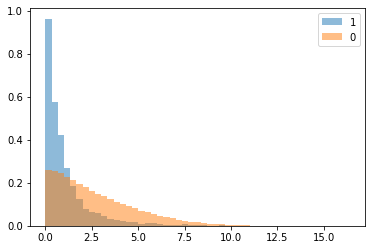

In [19]:
df_dropped = df.copy().dropna()
bins = np.linspace(min(df_dropped.mean_gross_diff.values), max(df_dropped.mean_gross_diff.values), 50)
plt.hist(df_dropped[df_dropped["collab indicator"] == 1].mean_gross_diff.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df_dropped[df_dropped["collab indicator"] == 0].mean_gross_diff.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()


In [20]:

print('mean_gross_diff variance in pairs w/ collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 1].mean_gross_diff.values)))
print('mean_gross_diff variance in pairs w/o collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 0].mean_gross_diff.values)))
ttest_ind(df_dropped[df_dropped["collab indicator"] == 1].mean_gross_diff.values, 
                      df_dropped[df_dropped["collab indicator"] == 0].mean_gross_diff.values, 
                      equal_var=False)


mean_gross_diff variance in pairs w/ collab is  1.8717488343183828
mean_gross_diff variance in pairs w/o collab is  4.674393288822889


Ttest_indResult(statistic=-94.2502745118173, pvalue=0.0)

In [21]:
ks_2samp(df_dropped[df_dropped["collab indicator"] == 1].mean_gross_diff.values, 
                      df_dropped[df_dropped["collab indicator"] == 0].mean_gross_diff.values)

KstestResult(statistic=0.4163505134945335, pvalue=0.0)

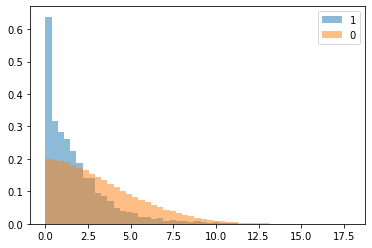

In [22]:
df_dropped = df.copy().dropna()
bins = np.linspace(min(df_dropped.total_gross_diff.values), max(df_dropped.total_gross_diff.values), 50)
plt.hist(df_dropped[df_dropped["collab indicator"] == 1].total_gross_diff.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df_dropped[df_dropped["collab indicator"] == 0].total_gross_diff.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()

In [23]:
print('total_gross_diff variance in pairs w/ collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 1].total_gross_diff.values)))
print('total_gross_diff variance in pairs w/o collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 0].total_gross_diff.values)))
ttest_ind(df_dropped[df_dropped["collab indicator"] == 1].total_gross_diff.values, 
                      df_dropped[df_dropped["collab indicator"] == 0].total_gross_diff.values, 
                      equal_var=False)


total_gross_diff variance in pairs w/ collab is  3.535748103826909
total_gross_diff variance in pairs w/o collab is  6.051382016033917


Ttest_indResult(statistic=-60.643563937183735, pvalue=0.0)

In [24]:
ks_2samp(df_dropped[df_dropped["collab indicator"] == 1].total_gross_diff.values, 
                      df_dropped[df_dropped["collab indicator"] == 0].total_gross_diff.values)

KstestResult(statistic=0.2814756160207849, pvalue=0.0)

### budget

In [25]:
actor_total_budget = {}
actor_mean_budget = {}
add_feature_actor(actor_total_budget, actor_mean_budget, 'budget')
df["actor_total_budget"] = df.actor.map(actor_total_budget)
df["actor_mean_budget"] = df.actor.map(actor_mean_budget)

df["actor_total_budget"] = np.log(df["actor_total_budget"]+1)
df["actor_mean_budget"] = np.log(df["actor_mean_budget"]+1)

director_total_budget = {}
director_mean_budget = {}
add_feature_director(director_total_budget, director_mean_budget, 'budget')
df["director_total_budget"] = df.director.map(director_total_budget)
df["director_mean_budget"] = df.director.map(director_mean_budget)

df["director_total_budget"] = np.log(df["director_total_budget"]+1)
df["director_mean_budget"] = np.log(df["director_mean_budget"]+1)


df["total_budget_diff"] = abs(df.director_total_budget - df.actor_total_budget)
df["mean_budget_diff"] = abs(df.director_mean_budget - df.actor_mean_budget)
df.head()

,director,actor,collabs,collab indicator,actor_total_gross,actor_mean_gross,director_total_gross,director_mean_gross,total_gross_diff,mean_gross_diff,actor_total_budget,actor_mean_budget,director_total_budget,director_mean_budget,total_budget_diff,mean_budget_diff
0,Pascal Chaumeil,Leo Fong,0,0,11.064464,11.064464,13.156038,12.462893,2.091574,1.398429,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,Pascal Chaumeil,Catherine Keener,0,0,15.247479,15.247479,13.156038,12.462893,2.091441,2.784586,12.429220,12.429220,0.0,0.0,12.429220,12.429220
2,Pascal Chaumeil,Lorraine Bracco,0,0,15.748856,15.055708,13.156038,12.462893,2.592818,2.592816,17.654963,16.961816,0.0,0.0,17.654963,16.961816
3,Pascal Chaumeil,Priscilla C. Shirer,0,0,18.031927,18.031927,13.156038,12.462893,4.875889,5.569034,14.914123,14.914123,0.0,0.0,14.914123,14.914123
4,Pascal Chaumeil,Terrence Howard,0,0,16.915677,16.915677,13.156038,12.462893,3.759639,4.452784,15.894952,15.894952,0.0,0.0,15.894952,15.894952


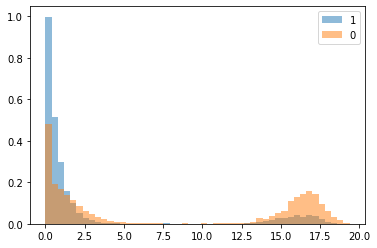

In [26]:
df_dropped = df.copy().dropna()
bins = np.linspace(min(df_dropped.mean_budget_diff.values), max(df_dropped.mean_budget_diff.values), 50)
plt.hist(df_dropped[df_dropped["collab indicator"] == 1].mean_budget_diff.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df_dropped[df_dropped["collab indicator"] == 0].mean_budget_diff.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()



In [27]:
from scipy.stats import ttest_ind
print('mean_budget_diff variance in pairs w/ collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 1].mean_budget_diff.values)))
print('mean_budget_diff variance in pairs w/o collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 0].mean_budget_diff.values)))
ttest_ind(df_dropped[df_dropped["collab indicator"] == 1].mean_budget_diff.values, 
                      df_dropped[df_dropped["collab indicator"] == 0].mean_budget_diff.values, 
                      equal_var=False)


mean_budget_diff variance in pairs w/ collab is  27.11462593108785
mean_budget_diff variance in pairs w/o collab is  57.83057142951253


Ttest_indResult(statistic=-80.27229668729034, pvalue=0.0)

In [28]:
ks_2samp(df_dropped[df_dropped["collab indicator"] == 1].mean_budget_diff.values, 
                      df_dropped[df_dropped["collab indicator"] == 0].mean_budget_diff.values)

KstestResult(statistic=0.39468762376419353, pvalue=0.0)

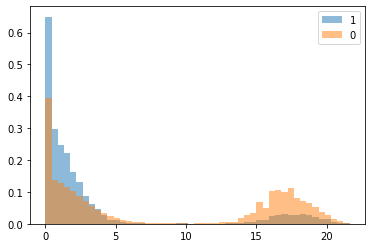

In [29]:
df_dropped = df.copy().dropna()
bins = np.linspace(min(df_dropped.total_budget_diff.values), max(df_dropped.total_budget_diff.values), 50)
plt.hist(df_dropped[df_dropped["collab indicator"] == 1].total_budget_diff.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df_dropped[df_dropped["collab indicator"] == 0].total_budget_diff.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()

In [30]:
print('total_budget_diff variance in pairs w/ collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 1].total_budget_diff.values)))
print('total_budget_diff variance in pairs w/o collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 0].total_budget_diff.values)))
ttest_ind(df_dropped[df_dropped["collab indicator"] == 1].total_budget_diff.values, 
                      df_dropped[df_dropped["collab indicator"] == 0].total_budget_diff.values, 
                      equal_var=False)


total_budget_diff variance in pairs w/ collab is  31.96133387977165
total_budget_diff variance in pairs w/o collab is  61.68560872797593


Ttest_indResult(statistic=-71.82662855761772, pvalue=0.0)

In [31]:
ks_2samp(df_dropped[df_dropped["collab indicator"] == 1].total_budget_diff.values, 
                      df_dropped[df_dropped["collab indicator"] == 0].total_budget_diff.values)

KstestResult(statistic=0.3394780088261523, pvalue=0.0)

### score

In [32]:
actor_total_score = {}
actor_mean_score = {}
add_feature_actor(actor_total_score, actor_mean_score, 'score')
df["actor_total_score"] = df.actor.map(actor_total_score)
df["actor_mean_score"] = df.actor.map(actor_mean_score)

df["actor_total_score"] = np.log(df["actor_total_score"]+1)
df["actor_mean_score"] = np.log(df["actor_mean_score"]+1)

director_total_score = {}
director_mean_score = {}
add_feature_director(director_total_score, director_mean_score, 'score')
df["director_total_score"] = df.director.map(director_total_score)
df["director_mean_score"] = df.director.map(director_mean_score)

df["director_total_score"] = np.log(df["actor_total_score"]+1)
df["director_mean_score"] = np.log(df["actor_mean_score"]+1)

df["total_score_diff"] = abs(df.director_total_score - df.actor_total_score)
df["mean_score_diff"] = abs(df.director_mean_score - df.actor_mean_score)
df.head()

,director,actor,collabs,collab indicator,actor_total_gross,actor_mean_gross,director_total_gross,director_mean_gross,total_gross_diff,mean_gross_diff,...,director_total_budget,director_mean_budget,total_budget_diff,mean_budget_diff,actor_total_score,actor_mean_score,director_total_score,director_mean_score,total_score_diff,mean_score_diff
0,Pascal Chaumeil,Leo Fong,0,0,11.064464,11.064464,13.156038,12.462893,2.091574,1.398429,...,0.0,0.0,0.000000,0.000000,1.504077,1.504077,0.917920,0.917920,0.586157,0.586157
1,Pascal Chaumeil,Catherine Keener,0,0,15.247479,15.247479,13.156038,12.462893,2.091441,2.784586,...,0.0,0.0,12.429220,12.429220,2.066863,2.066863,1.120655,1.120655,0.946208,0.946208
2,Pascal Chaumeil,Lorraine Bracco,0,0,15.748856,15.055708,13.156038,12.462893,2.592818,2.592816,...,0.0,0.0,17.654963,16.961816,2.687847,2.060514,1.305043,1.118583,1.382805,0.941931
3,Pascal Chaumeil,Priscilla C. Shirer,0,0,18.031927,18.031927,13.156038,12.462893,4.875889,5.569034,...,0.0,0.0,14.914123,14.914123,2.001480,2.001480,1.099106,1.099106,0.902374,0.902374
4,Pascal Chaumeil,Terrence Howard,0,0,16.915677,16.915677,13.156038,12.462893,3.759639,4.452784,...,0.0,0.0,15.894952,15.894952,2.128232,2.128232,1.140468,1.140468,0.987764,0.987764


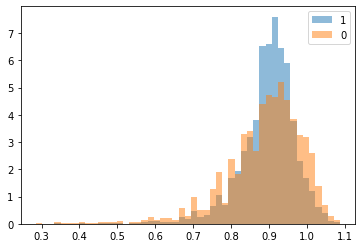

In [33]:
df_dropped = df.copy().dropna()
bins = np.linspace(min(df_dropped.mean_score_diff.values), max(df_dropped.mean_score_diff.values), 50)
plt.hist(df_dropped[df_dropped["collab indicator"] == 1].mean_score_diff.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df_dropped[df_dropped["collab indicator"] == 0].mean_score_diff.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()


In [34]:
print('mean_score_diff variance in pairs w/ collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 1].mean_score_diff.values)))
print('mean_score_diff variance in pairs w/o collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 0].mean_score_diff.values)))
ttest_ind(df_dropped[df_dropped["collab indicator"] == 1].mean_score_diff.values, 
                      df_dropped[df_dropped["collab indicator"] == 0].mean_score_diff.values, 
                      equal_var=False)


mean_score_diff variance in pairs w/ collab is  0.005874329111945941
mean_score_diff variance in pairs w/o collab is  0.010481064026380918


Ttest_indResult(statistic=7.301656502374464, pvalue=3.191666809125915e-13)

In [35]:
ks_2samp(df_dropped[df_dropped["collab indicator"] == 1].mean_score_diff.values, 
                      df_dropped[df_dropped["collab indicator"] == 0].mean_score_diff.values)

KstestResult(statistic=0.10050500770808812, pvalue=7.4792172391244485e-56)

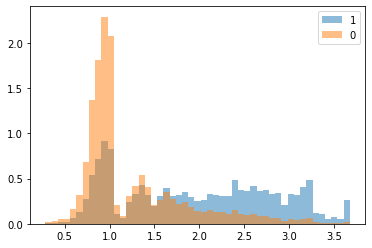

In [36]:
bins = np.linspace(min(df_dropped.total_score_diff.values), max(df_dropped.total_score_diff.values), 50)
plt.hist(df_dropped[df_dropped["collab indicator"] == 1].total_score_diff.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df_dropped[df_dropped["collab indicator"] == 0].total_score_diff.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()


In [37]:
print('total_score_diff variance in pairs w/ collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 1].total_score_diff.values)))
print('total_score_diff variance in pairs w/o collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 0].total_score_diff.values)))
ttest_ind(df_dropped[df_dropped["collab indicator"] == 1].total_score_diff.values, 
                      df_dropped[df_dropped["collab indicator"] == 0].total_score_diff.values, 
                      equal_var=False)


total_score_diff variance in pairs w/ collab is  0.72134811819559
total_score_diff variance in pairs w/o collab is  0.34578967934503785


Ttest_indResult(statistic=67.43183772483678, pvalue=0.0)

In [38]:
ks_2samp(df_dropped[df_dropped["collab indicator"] == 1].total_score_diff.values, 
                      df_dropped[df_dropped["collab indicator"] == 0].total_score_diff.values)

KstestResult(statistic=0.4046545705185453, pvalue=0.0)

### votes

In [39]:
actor_total_votes = {}
actor_mean_votes = {}
add_feature_actor(actor_total_votes, actor_mean_votes, 'votes')
df["actor_total_votes"] = df.actor.map(actor_total_votes)
df["actor_mean_votes"] = df.actor.map(actor_mean_votes)

df["actor_total_votes"] = np.log(df["actor_total_score"]+1)
df["actor_mean_votes"] = np.log(df["actor_mean_score"]+1)

director_total_votes = {}
director_mean_votes = {}
add_feature_director(director_total_votes, director_mean_votes, 'votes')
df["director_total_votes"] = df.director.map(director_total_votes)
df["director_mean_votes"] = df.director.map(director_mean_votes)

df["director_total_votes"] = np.log(df["actor_total_votes"]+1)
df["director_mean_votes"] = np.log(df["actor_mean_votes"]+1)

df["total_votes_diff"] = abs(df.director_total_votes - df.actor_total_votes)
df["mean_votes_diff"] = abs(df.director_mean_votes - df.actor_mean_votes)
df.head()

,director,actor,collabs,collab indicator,actor_total_gross,actor_mean_gross,director_total_gross,director_mean_gross,total_gross_diff,mean_gross_diff,...,director_total_score,director_mean_score,total_score_diff,mean_score_diff,actor_total_votes,actor_mean_votes,director_total_votes,director_mean_votes,total_votes_diff,mean_votes_diff
0,Pascal Chaumeil,Leo Fong,0,0,11.064464,11.064464,13.156038,12.462893,2.091574,1.398429,...,0.917920,0.917920,0.586157,0.586157,0.917920,0.917920,0.651241,0.651241,0.266679,0.266679
1,Pascal Chaumeil,Catherine Keener,0,0,15.247479,15.247479,13.156038,12.462893,2.091441,2.784586,...,1.120655,1.120655,0.946208,0.946208,1.120655,1.120655,0.751725,0.751725,0.368930,0.368930
2,Pascal Chaumeil,Lorraine Bracco,0,0,15.748856,15.055708,13.156038,12.462893,2.592818,2.592816,...,1.305043,1.118583,1.382805,0.941931,1.305043,1.118583,0.835099,0.750747,0.469944,0.367835
3,Pascal Chaumeil,Priscilla C. Shirer,0,0,18.031927,18.031927,13.156038,12.462893,4.875889,5.569034,...,1.099106,1.099106,0.902374,0.902374,1.099106,1.099106,0.741511,0.741511,0.357594,0.357594
4,Pascal Chaumeil,Terrence Howard,0,0,16.915677,16.915677,13.156038,12.462893,3.759639,4.452784,...,1.140468,1.140468,0.987764,0.987764,1.140468,1.140468,0.761024,0.761024,0.379443,0.379443


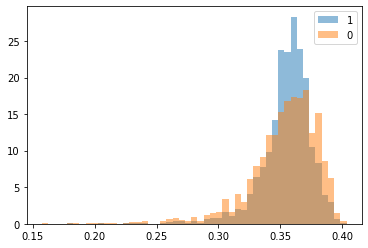

In [40]:
df_dropped = df.copy().dropna()
bins = np.linspace(min(df_dropped.mean_votes_diff.values), max(df_dropped.mean_votes_diff.values), 50)
plt.hist(df_dropped[df_dropped["collab indicator"] == 1].mean_votes_diff.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df_dropped[df_dropped["collab indicator"] == 0].mean_votes_diff.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()

In [41]:
print('mean_votes_diff variance in pairs w/ collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 1].mean_votes_diff.values)))
print('mean_votes_diff variance in pairs w/o collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 0].mean_votes_diff.values)))
ttest_ind(df_dropped[df_dropped["collab indicator"] == 1].mean_votes_diff.values, 
                      df_dropped[df_dropped["collab indicator"] == 0].mean_votes_diff.values, 
                      equal_var=False)


mean_votes_diff variance in pairs w/ collab is  0.0004410433130685239
mean_votes_diff variance in pairs w/o collab is  0.0008018061535060452


Ttest_indResult(statistic=8.38700963963717, pvalue=6.088255641671339e-17)

In [42]:
ks_2samp(df_dropped[df_dropped["collab indicator"] == 1].mean_votes_diff.values, 
                      df_dropped[df_dropped["collab indicator"] == 0].mean_votes_diff.values)

KstestResult(statistic=0.10042856155868363, pvalue=9.084698695103497e-56)

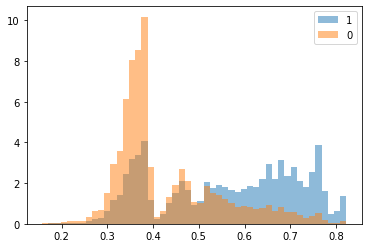

In [43]:
bins = np.linspace(min(df_dropped.total_votes_diff.values), max(df_dropped.total_votes_diff.values), 50)
plt.hist(df_dropped[df_dropped["collab indicator"] == 1].total_votes_diff.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df_dropped[df_dropped["collab indicator"] == 0].total_votes_diff.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()

In [44]:
print('total_votes_diff variance in pairs w/ collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 1].total_votes_diff.values)))
print('total_votes_diff variance in pairs w/o collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 0].total_votes_diff.values)))
ttest_ind(df_dropped[df_dropped["collab indicator"] == 1].total_votes_diff.values, 
                      df_dropped[df_dropped["collab indicator"] == 0].total_votes_diff.values, 
                      equal_var=False)


total_votes_diff variance in pairs w/ collab is  0.023320523060240975
total_votes_diff variance in pairs w/o collab is  0.01354146140562077


Ttest_indResult(statistic=69.93377999403013, pvalue=0.0)

In [45]:
ks_2samp(df_dropped[df_dropped["collab indicator"] == 1].total_votes_diff.values, 
                      df_dropped[df_dropped["collab indicator"] == 0].total_votes_diff.values)

KstestResult(statistic=0.4046545705185453, pvalue=0.0)

### oscar nomination

In [46]:
oscar = pd.read_csv("../data/the_oscar_award.csv")
oscar.head()

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False


In [47]:
oscar.category = oscar.category.str.lower()
filtered = oscar[oscar.category.str.contains("(actor)|(actress)|(directing)", regex = True)]
filtered

/opt/miniconda3/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,actor,Richard Barthelmess,The Noose,False
1,1927,1928,1,actor,Emil Jannings,The Last Command,True
2,1927,1928,1,actress,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,actress,Janet Gaynor,7th Heaven,True
4,1927,1928,1,actress,Gloria Swanson,Sadie Thompson,False
...,...,...,...,...,...,...,...
10302,2019,2020,92,directing,Martin Scorsese,The Irishman,False
10303,2019,2020,92,directing,Todd Phillips,Joker,False
10304,2019,2020,92,directing,Sam Mendes,1917,False
10305,2019,2020,92,directing,Quentin Tarantino,Once upon a Time...in Hollywood,False


In [48]:
filtered.loc[filtered.category.str.contains("(actor)|(actress)"), 'is_director'] = 0
filtered.loc[filtered.category.str.contains("directing"), 'is_director'] = 1

/opt/miniconda3/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/opt/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [49]:
oscar_ppl = filtered[~filtered.name.str.contains("( and)|(,)|(and )", regex = True)]
oscar_ppl.is_director = oscar_ppl.is_director.astype(np.uint8)
oscar_ppl.head()


/opt/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,year_film,year_ceremony,ceremony,category,name,film,winner,is_director
0,1927,1928,1,actor,Richard Barthelmess,The Noose,False,0
1,1927,1928,1,actor,Emil Jannings,The Last Command,True,0
2,1927,1928,1,actress,Louise Dresser,A Ship Comes In,False,0
3,1927,1928,1,actress,Janet Gaynor,7th Heaven,True,0
4,1927,1928,1,actress,Gloria Swanson,Sadie Thompson,False,0


In [50]:
gp_ppl = oscar_ppl.groupby(['name', 'is_director']).size().reset_index(name='nomination_counts')
gp_ppl_director = gp_ppl.groupby(['is_director']).get_group(1)
gp_ppl_actor = gp_ppl.groupby(['is_director']).get_group(0)
gp_ppl_director.head()

,name,is_director,nomination_counts
2,Adam McKay,1,2
5,Adrian Lyne,1,1
10,Akira Kurosawa,1,1
15,Alan J. Pakula,1,1
16,Alan Parker,1,2


In [51]:
gp_ppl_actor.head()

,name,is_director,nomination_counts
0,Abigail Breslin,0,1
1,Adam Driver,0,2
3,Adolph Caesar,0,1
4,Adolphe Menjou,0,1
6,Adriana Barraza,0,1


In [52]:
df_w_oscar= pd.merge(df, gp_ppl_director, left_on='director', right_on='name')
df_w_oscar= pd.merge(df_w_oscar, gp_ppl_actor, left_on='actor', right_on='name')
df_w_oscar.drop(['name_x', 'is_director_x', 'name_y', 'is_director_y'], axis=1, inplace=True)
df_w_oscar.rename(columns={'nomination_counts_x': 'director_nominations', 'nomination_counts_y': 'actor_nominations'}, inplace=True)
df_w_oscar.head()

,director,actor,collabs,collab indicator,actor_total_gross,actor_mean_gross,director_total_gross,director_mean_gross,total_gross_diff,mean_gross_diff,...,total_score_diff,mean_score_diff,actor_total_votes,actor_mean_votes,director_total_votes,director_mean_votes,total_votes_diff,mean_votes_diff,director_nominations,actor_nominations
0,Hector Babenco,Catherine Keener,0,0,15.247479,15.247479,16.007187,14.908575,0.759708,0.338904,...,0.946208,0.946208,1.120655,1.120655,0.751725,0.751725,0.36893,0.36893,1,2
1,Roman Polanski,Catherine Keener,0,0,15.247479,15.247479,18.368319,16.065734,3.120840,0.818255,...,0.946208,0.946208,1.120655,1.120655,0.751725,0.751725,0.36893,0.36893,3,2
2,Ang Lee,Catherine Keener,0,0,15.247479,15.247479,20.121941,17.556992,4.874463,2.309513,...,0.946208,0.946208,1.120655,1.120655,0.751725,0.751725,0.36893,0.36893,3,2
3,Alan Parker,Catherine Keener,0,0,15.247479,15.247479,18.870122,16.790680,3.622643,1.543201,...,0.946208,0.946208,1.120655,1.120655,0.751725,0.751725,0.36893,0.36893,2,2
4,Tom Hooper,Catherine Keener,0,0,15.247479,15.247479,19.521834,18.135539,4.274355,2.888061,...,0.946208,0.946208,1.120655,1.120655,0.751725,0.751725,0.36893,0.36893,1,2


In [53]:
df_w_oscar['nominations_diff']=df_w_oscar['director_nominations'] - df_w_oscar['actor_nominations']
df_w_oscar.head()

,director,actor,collabs,collab indicator,actor_total_gross,actor_mean_gross,director_total_gross,director_mean_gross,total_gross_diff,mean_gross_diff,...,mean_score_diff,actor_total_votes,actor_mean_votes,director_total_votes,director_mean_votes,total_votes_diff,mean_votes_diff,director_nominations,actor_nominations,nominations_diff
0,Hector Babenco,Catherine Keener,0,0,15.247479,15.247479,16.007187,14.908575,0.759708,0.338904,...,0.946208,1.120655,1.120655,0.751725,0.751725,0.36893,0.36893,1,2,-1
1,Roman Polanski,Catherine Keener,0,0,15.247479,15.247479,18.368319,16.065734,3.120840,0.818255,...,0.946208,1.120655,1.120655,0.751725,0.751725,0.36893,0.36893,3,2,1
2,Ang Lee,Catherine Keener,0,0,15.247479,15.247479,20.121941,17.556992,4.874463,2.309513,...,0.946208,1.120655,1.120655,0.751725,0.751725,0.36893,0.36893,3,2,1
3,Alan Parker,Catherine Keener,0,0,15.247479,15.247479,18.870122,16.790680,3.622643,1.543201,...,0.946208,1.120655,1.120655,0.751725,0.751725,0.36893,0.36893,2,2,0
4,Tom Hooper,Catherine Keener,0,0,15.247479,15.247479,19.521834,18.135539,4.274355,2.888061,...,0.946208,1.120655,1.120655,0.751725,0.751725,0.36893,0.36893,1,2,-1


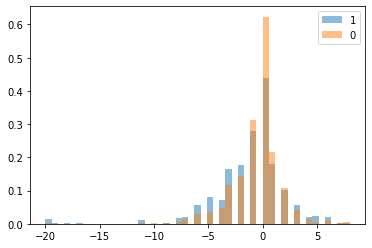

In [54]:
bins = np.linspace(min(df_w_oscar.nominations_diff.values), max(df_w_oscar.nominations_diff.values), 50)
plt.hist(df_w_oscar[df_w_oscar["collab indicator"] == 1].nominations_diff.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df_w_oscar[df_w_oscar["collab indicator"] == 0].nominations_diff.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()

In [55]:
print('nominations_diff variance in pairs w/ collab is  {}'.format(np.var(df_w_oscar[df_w_oscar["collab indicator"] == 1].nominations_diff.values)))
print('nominations_diff variance in pairs w/o collab is  {}'.format(np.var(df_w_oscar[df_w_oscar["collab indicator"] == 0].nominations_diff.values)))
ttest_ind(df_w_oscar[df_w_oscar["collab indicator"] == 1].nominations_diff.values, 
                      df_w_oscar[df_w_oscar["collab indicator"] == 0].nominations_diff.values, 
                      equal_var=False)


nominations_diff variance in pairs w/ collab is  11.675624990825147
nominations_diff variance in pairs w/o collab is  5.747848063463026


Ttest_indResult(statistic=-3.9763645704487445, pvalue=7.977315478395336e-05)

In [56]:
ks_2samp(df_w_oscar[df_w_oscar["collab indicator"] == 1].nominations_diff.values, 
                      df_w_oscar[df_w_oscar["collab indicator"] == 0].nominations_diff.values)

KstestResult(statistic=0.1219562047148254, pvalue=3.6913563012315924e-07)

### oscar win

In [76]:
oscar_ppl.head()

,year_film,year_ceremony,ceremony,category,name,film,winner,is_director
0,1927,1928,1,actor,Richard Barthelmess,The Noose,False,0
1,1927,1928,1,actor,Emil Jannings,The Last Command,True,0
2,1927,1928,1,actress,Louise Dresser,A Ship Comes In,False,0
3,1927,1928,1,actress,Janet Gaynor,7th Heaven,True,0
4,1927,1928,1,actress,Gloria Swanson,Sadie Thompson,False,0


In [83]:
gp_pplw = oscar_ppl.groupby(['name', 'is_director']).agg({'winner': 'sum'}).reset_index()
gp_pplw_director = gp_pplw.groupby(['is_director']).get_group(1)
gp_pplw_actor = gp_pplw.groupby(['is_director']).get_group(0)
gp_pplw_director.head()


,name,is_director,winner
2,Adam McKay,1,0
5,Adrian Lyne,1,0
10,Akira Kurosawa,1,0
15,Alan J. Pakula,1,0
16,Alan Parker,1,0


In [84]:
gp_pplw_actor.head()

,name,is_director,winner
0,Abigail Breslin,0,0
1,Adam Driver,0,0
3,Adolph Caesar,0,0
4,Adolphe Menjou,0,0
6,Adriana Barraza,0,0


In [87]:
df_w_oscar2= pd.merge(df, gp_pplw_director, left_on='director', right_on='name')
df_w_oscar2= pd.merge(df_w_oscar2, gp_pplw_actor, left_on='actor', right_on='name')
df_w_oscar2.drop(['name_x', 'is_director_x', 'name_y', 'is_director_y'], axis=1, inplace=True)
df_w_oscar2.rename(columns={'winner_x': 'director_wins', 'winner_y': 'actor_wins'}, inplace=True)
df_w_oscar2.head()

,director,actor,collabs,collab indicator,actor_total_gross,actor_mean_gross,director_total_gross,director_mean_gross,total_gross_diff,mean_gross_diff,...,actor_total_votes,actor_mean_votes,director_total_votes,director_mean_votes,total_votes_diff,mean_votes_diff,genre_tvd,rating_tvd,director_wins,actor_wins
0,Hector Babenco,Catherine Keener,0,0,15.247479,15.247479,16.007187,14.908575,0.759708,0.338904,...,1.120655,1.120655,0.751725,0.751725,0.36893,0.36893,1.000000,0.000000,0,0
1,Roman Polanski,Catherine Keener,0,0,15.247479,15.247479,18.368319,16.065734,3.120840,0.818255,...,1.120655,1.120655,0.751725,0.751725,0.36893,0.36893,0.900000,0.400000,1,0
2,Ang Lee,Catherine Keener,0,0,15.247479,15.247479,20.121941,17.556992,4.874463,2.309513,...,1.120655,1.120655,0.751725,0.751725,0.36893,0.36893,0.769231,0.538462,2,0
3,Alan Parker,Catherine Keener,0,0,15.247479,15.247479,18.870122,16.790680,3.622643,1.543201,...,1.120655,1.120655,0.751725,0.751725,0.36893,0.36893,0.750000,0.125000,0,0
4,Tom Hooper,Catherine Keener,0,0,15.247479,15.247479,19.521834,18.135539,4.274355,2.888061,...,1.120655,1.120655,0.751725,0.751725,0.36893,0.36893,1.000000,0.250000,1,0


In [90]:
df_w_oscar2['wins_diff']=df_w_oscar2['director_wins'] - df_w_oscar2['actor_wins']
df_w_oscar2.head()

,director,actor,collabs,collab indicator,actor_total_gross,actor_mean_gross,director_total_gross,director_mean_gross,total_gross_diff,mean_gross_diff,...,actor_mean_votes,director_total_votes,director_mean_votes,total_votes_diff,mean_votes_diff,genre_tvd,rating_tvd,director_wins,actor_wins,wins_diff
0,Hector Babenco,Catherine Keener,0,0,15.247479,15.247479,16.007187,14.908575,0.759708,0.338904,...,1.120655,0.751725,0.751725,0.36893,0.36893,1.000000,0.000000,0,0,0
1,Roman Polanski,Catherine Keener,0,0,15.247479,15.247479,18.368319,16.065734,3.120840,0.818255,...,1.120655,0.751725,0.751725,0.36893,0.36893,0.900000,0.400000,1,0,1
2,Ang Lee,Catherine Keener,0,0,15.247479,15.247479,20.121941,17.556992,4.874463,2.309513,...,1.120655,0.751725,0.751725,0.36893,0.36893,0.769231,0.538462,2,0,2
3,Alan Parker,Catherine Keener,0,0,15.247479,15.247479,18.870122,16.790680,3.622643,1.543201,...,1.120655,0.751725,0.751725,0.36893,0.36893,0.750000,0.125000,0,0,0
4,Tom Hooper,Catherine Keener,0,0,15.247479,15.247479,19.521834,18.135539,4.274355,2.888061,...,1.120655,0.751725,0.751725,0.36893,0.36893,1.000000,0.250000,1,0,1


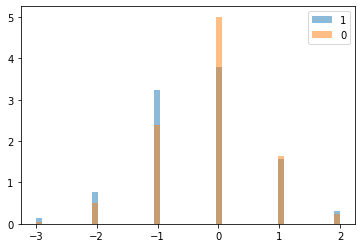

In [92]:
bins = np.linspace(min(df_w_oscar2.wins_diff.values), max(df_w_oscar2.wins_diff.values), 50)
plt.hist(df_w_oscar2[df_w_oscar2["collab indicator"] == 1].wins_diff.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df_w_oscar2[df_w_oscar2["collab indicator"] == 0].wins_diff.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()

In [93]:
print('wins_diff variance in pairs w/ collab is  {}'.format(np.var(df_w_oscar2[df_w_oscar2["collab indicator"] == 1].wins_diff.values)))
print('wins_diff variance in pairs w/o collab is  {}'.format(np.var(df_w_oscar2[df_w_oscar2["collab indicator"] == 0].wins_diff.values)))
ttest_ind(df_w_oscar2[df_w_oscar2["collab indicator"] == 1].wins_diff.values, 
                      df_w_oscar2[df_w_oscar2["collab indicator"] == 0].wins_diff.values, 
                      equal_var=False)

wins_diff variance in pairs w/ collab is  0.9620234582580995
wins_diff variance in pairs w/o collab is  0.7220626151863508


Ttest_indResult(statistic=-3.769840622715144, pvalue=0.0001817717209518124)

In [94]:
ks_2samp(df_w_oscar2[df_w_oscar2["collab indicator"] == 1].wins_diff.values, 
                      df_w_oscar2[df_w_oscar2["collab indicator"] == 0].wins_diff.values)

KstestResult(statistic=0.12364465906785654, pvalue=2.394910165601113e-07)

### genre

In [57]:
genre = np.unique(movie_industry.genre.values)
genre

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Horror', 'Other_genre'], dtype=object)

In [58]:
dir_genre_prop = {}
for director in directors:
    temp = movie_industry[movie_industry.director == director].groupby(["genre"])["director"].count()
    prop = []
    total = sum(temp.values)
    for category in genre:
        if category in temp.index:
            prop.append(temp[category]/total)
        else:
            prop.append(0)
    dir_genre_prop[director] = np.array(prop)

In [59]:
act_genre_prop = {}
for actor in actors:
    temp = movie_industry[movie_industry.star == actor].groupby(["genre"])["star"].count()
    prop = []
    total = sum(temp.values)
    for category in genre:
        if category in temp.index:
            prop.append(temp[category]/total)
        else:
            prop.append(0)
    act_genre_prop[actor] = np.array(prop)

In [60]:
%%time
genre_tvd = []
for i in df.index:
    director = df.director[i]
    actor = df.actor[i]
    tvd = sum(abs(dir_genre_prop[director] - act_genre_prop[actor]))/2
    genre_tvd.append(tvd)

CPU times: user 2min 24s, sys: 459 ms, total: 2min 25s
Wall time: 2min 25s


In [61]:
df["genre_tvd"] = genre_tvd

In [62]:
bins = np.linspace(min(genre_tvd), max(genre_tvd), 20)
bins

array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])

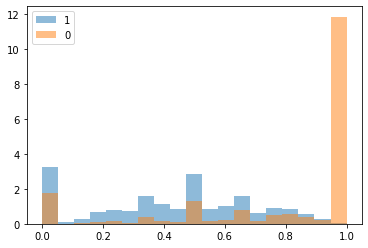

In [63]:
plt.hist(df[df["collab indicator"] == 1].genre_tvd.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df[df["collab indicator"] == 0].genre_tvd.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()

In [64]:
ttest_ind(df[df["collab indicator"] == 1].genre_tvd.values, 
                      df[df["collab indicator"] == 0].genre_tvd.values, 
                      equal_var=False)

Ttest_indResult(statistic=-108.81833577459544, pvalue=0.0)

In [65]:
ks_2samp(df[df["collab indicator"] == 1].genre_tvd.values, 
                      df[df["collab indicator"] == 0].genre_tvd.values)

KstestResult(statistic=0.6221440027353479, pvalue=0.0)

### Rating 

In [66]:
rating = np.unique(movie_industry.rating.values)
rating

array(['G', 'NOT RATED', 'Other_rating', 'PG', 'PG-13', 'R'], dtype=object)

In [67]:
dir_rating_prop = {}
for director in directors:
    temp = movie_industry[movie_industry.director == director].groupby(["rating"])["director"].count()
    prop = []
    total = sum(temp.values)
    for category in rating:
        if category in temp.index:
            prop.append(temp[category]/total)
        else:
            prop.append(0)
    dir_rating_prop[director] = np.array(prop)

In [68]:
act_rating_prop = {}
for actor in actors:
    temp = movie_industry[movie_industry.star == actor].groupby(["rating"])["star"].count()
    prop = []
    total = sum(temp.values)
    for category in rating:
        if category in temp.index:
            prop.append(temp[category]/total)
        else:
            prop.append(0)
    act_rating_prop[actor] = np.array(prop)

In [69]:
%%time
rating_tvd = []
for i in df.index:
    director = df.director[i]
    actor = df.actor[i]
    tvd = sum(abs(dir_rating_prop[director] - act_rating_prop[actor]))/2
    rating_tvd.append(tvd)

CPU times: user 2min 27s, sys: 687 ms, total: 2min 28s
Wall time: 2min 28s


In [70]:
df["rating_tvd"] = rating_tvd

In [71]:
bins = np.linspace(min(rating_tvd), max(rating_tvd), 20)
bins

array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])

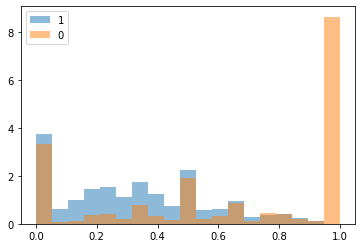

In [72]:
plt.hist(df[df["collab indicator"] == 1].rating_tvd.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df[df["collab indicator"] == 0].rating_tvd.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()

In [73]:
ttest_ind(df[df["collab indicator"] == 1].rating_tvd.values, 
                      df[df["collab indicator"] == 0].rating_tvd.values, 
                      equal_var=False)

Ttest_indResult(statistic=-105.86742361509394, pvalue=0.0)

In [74]:
ks_2samp(df[df["collab indicator"] == 1].rating_tvd.values, 
                      df[df["collab indicator"] == 0].rating_tvd.values)

KstestResult(statistic=0.4575513471661826, pvalue=0.0)

## Visualization

<Figure size 432x288 with 0 Axes>

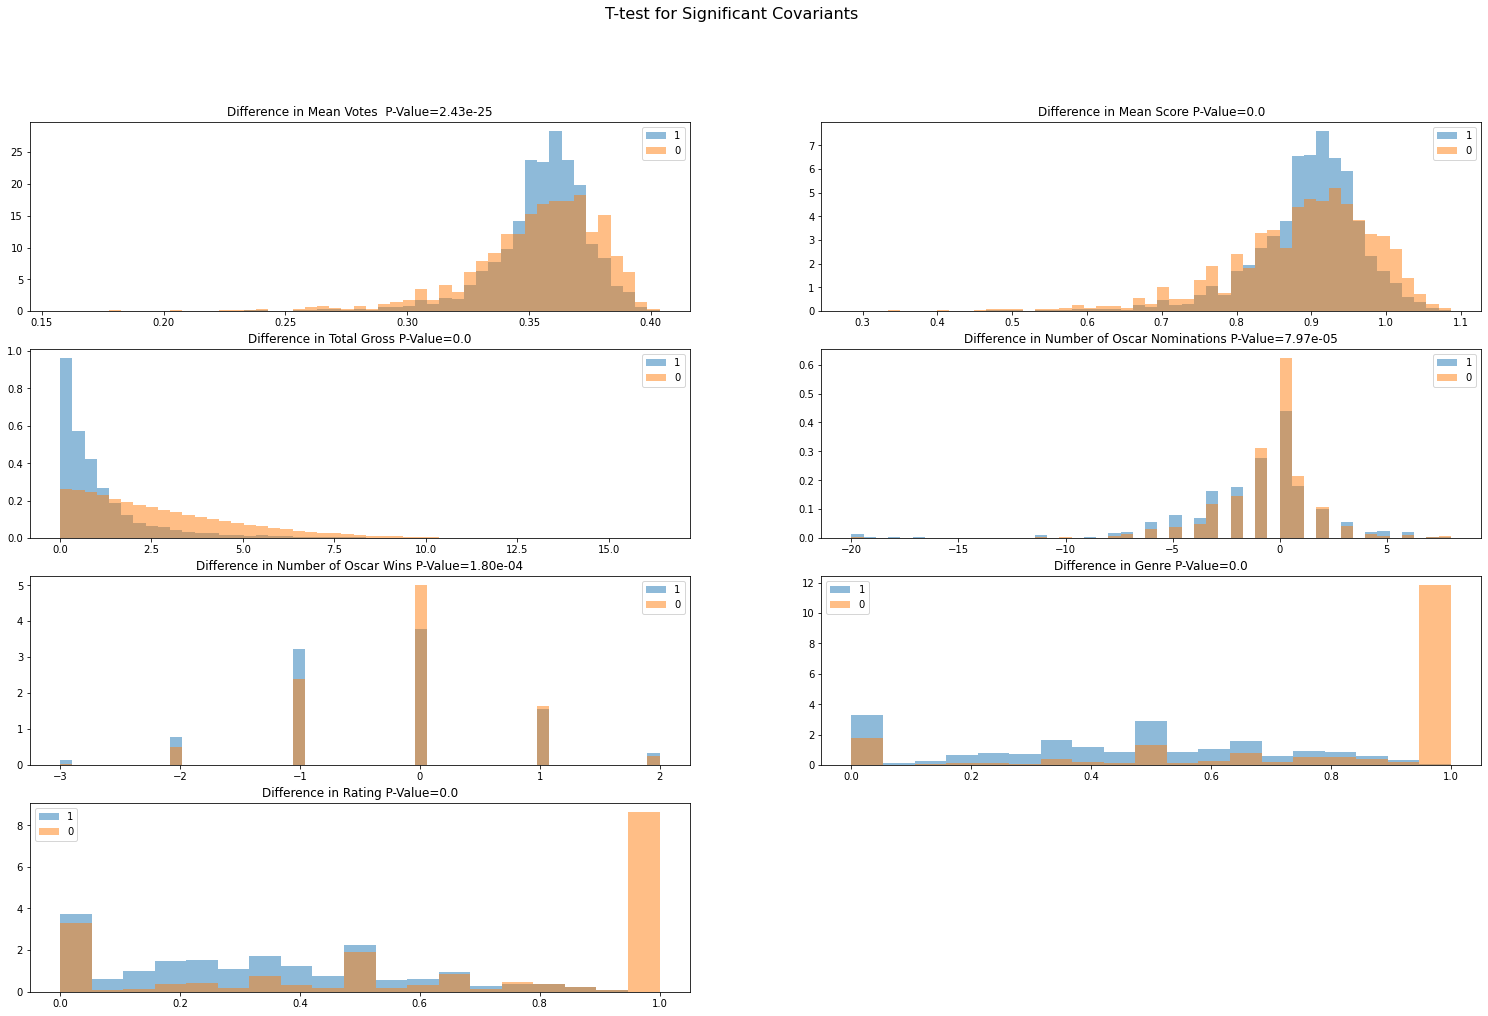

In [99]:
df_dropped = df.dropna()

fig = plt.figure()
f, axes = plt.subplots(4, 2, figsize=(26,16), sharex=False)
plt.suptitle("T-test for Significant Covariants", fontsize=16)

bins1 = np.linspace(min(df_dropped.mean_votes_diff.values), max(df_dropped.mean_votes_diff.values), 50)
axes[0, 0].hist(df_dropped[df_dropped["collab indicator"] == 1].mean_votes_diff.values, density = True, bins = bins1, label = "1", alpha = 0.5)
axes[0, 0].hist(df_dropped[df_dropped["collab indicator"] == 0].mean_votes_diff.values, density = True, bins = bins1, label = "0", alpha = 0.5)
axes[0, 0].legend()
axes[0, 0].title.set_text('Difference in Mean Votes  P-Value=2.43e-25')

bins2 = np.linspace(min(df_dropped.mean_score_diff.values), max(df_dropped.mean_score_diff.values), 50)
axes[0, 1].hist(df_dropped[df_dropped["collab indicator"] == 1].mean_score_diff.values, density = True, bins = bins2, label = "1", alpha = 0.5)
axes[0, 1].hist(df_dropped[df_dropped["collab indicator"] == 0].mean_score_diff.values, density = True, bins = bins2, label = "0", alpha = 0.5)
axes[0, 1].legend()
axes[0, 1].title.set_text('Difference in Mean Score P-Value=0.0')


bins3 = np.linspace(min(df_dropped.mean_gross_diff.values), max(df_dropped.mean_gross_diff.values), 50)
axes[1, 0].hist(df_dropped[df_dropped["collab indicator"] == 1].mean_gross_diff.values, density = True, bins = bins3, label = "1", alpha = 0.5)
axes[1, 0].hist(df_dropped[df_dropped["collab indicator"] == 0].mean_gross_diff.values, density = True, bins = bins3, label = "0", alpha = 0.5)
axes[1, 0].legend()
axes[1, 0].title.set_text('Difference in Total Gross P-Value=0.0')

bins4 = np.linspace(min(df_w_oscar.nominations_diff.values), max(df_w_oscar.nominations_diff.values), 50)
axes[1, 1].hist(df_w_oscar[df_w_oscar["collab indicator"] == 1].nominations_diff.values, density = True, bins = bins4, label = "1", alpha = 0.5)
axes[1, 1].hist(df_w_oscar[df_w_oscar["collab indicator"] == 0].nominations_diff.values, density = True, bins = bins4, label = "0", alpha = 0.5)
axes[1, 1].legend()
axes[1, 1].title.set_text('Difference in Number of Oscar Nominations P-Value=7.97e-05')

bins5 = np.linspace(min(df_w_oscar2.wins_diff.values), max(df_w_oscar2.wins_diff.values), 50)
axes[2, 0].hist(df_w_oscar2[df_w_oscar2["collab indicator"] == 1].wins_diff.values, density = True, bins = bins5, label = "1", alpha = 0.5)
axes[2, 0].hist(df_w_oscar2[df_w_oscar2["collab indicator"] == 0].wins_diff.values, density = True, bins = bins5, label = "0", alpha = 0.5)
axes[2, 0].legend()
axes[2, 0].title.set_text('Difference in Number of Oscar Wins P-Value=1.80e-04') 

bins6 = np.linspace(min(genre_tvd), max(genre_tvd), 20)
axes[2, 1].hist(df[df["collab indicator"] == 1].genre_tvd.values, density = True, bins = bins6, label = "1", alpha = 0.5)
axes[2, 1].hist(df[df["collab indicator"] == 0].genre_tvd.values, density = True, bins = bins6, label = "0", alpha = 0.5)
axes[2, 1].legend()
axes[2, 1].title.set_text('Difference in Genre P-Value=0.0')

bins7 = np.linspace(min(rating_tvd), max(rating_tvd), 20)
axes[3, 0].hist(df[df["collab indicator"] == 1].rating_tvd.values, density = True, bins = bins7, label = "1", alpha = 0.5)
axes[3, 0].hist(df[df["collab indicator"] == 0].rating_tvd.values, density = True, bins = bins7, label = "0", alpha = 0.5)
axes[3, 0].legend()
axes[3, 0].title.set_text('Difference in Rating P-Value=0.0')


axes[3,1].set_axis_off()

f.savefig('../figures/T-test_for_Significant_Covariants.png', bbox_inches='tight')
